In [61]:
import numpy as np
from sklearn.datasets import load_files
reviews_train=load_files("aclImdb/train/")
text_train, y_train=reviews_train.data, reviews_train.target

In [62]:
text_train=[doc.replace(b"<br /", b" ") for doc in text_train]

In [63]:
reviews_test=load_files("aclImdb/test/")
text_test, y_test=reviews_test.data, reviews_test.target
text_test=[doc.replace(b"<br /", b" ") for doc in text_test]

In [64]:
from sklearn.feature_extraction.text import CountVectorizer
vect=CountVectorizer(max_features=10000, max_df=.15)
X=vect.fit_transform(text_train)

In [65]:
from sklearn.decomposition import LatentDirichletAllocation
lda=LatentDirichletAllocation(n_components=10, learning_method="batch", max_iter=10, random_state=0)
document_topics=lda.fit_transform(X)

In [66]:
lda.components_.shape

(10, 10000)

In [67]:
sorting=np.argsort(lda.components_, axis=1)[:, ::-1]
feature_names=np.array(vect.get_feature_names_out())

In [68]:
import mglearn
mglearn.tools.print_topics(topics=range(10), feature_names=feature_names, sorting=sorting, topics_per_chunk=5, n_words=10)

topic 0       topic 1       topic 2       topic 3       topic 4       
--------      --------      --------      --------      --------      
between       war           funny         show          saw           
real          world         guy           series        didn          
performance   book          comedy        episode       am            
young         us            thing         tv            thought       
family        our           actually      episodes      dvd           
both          documentary   worst         shows         years         
director      work          re            season        got           
role          american      nothing       new           again         
actors        history       actors        years         now           
beautiful     point         want          family        watched       


topic 5       topic 6       topic 7       topic 8       topic 9       
--------      --------      --------      --------      --------      
acti

In [69]:
lda100=LatentDirichletAllocation(n_components=100, learning_method="batch", max_iter=10, random_state=0)
document_topics100=lda100.fit_transform(X)

In [70]:
topics=np.array([7,16,24,25,28,36,37,45,51,53,54,63, 89,97])
sorting=np.argsort(lda100.components_, axis=1)[:,::-1]
feature_names=np.array(vect.get_feature_names_out())
mglearn.tools.print_topics(topics=topics, feature_names=feature_names,sorting=sorting,topics_per_chunk=7,n_words=20)

topic 7       topic 16      topic 24      topic 25      topic 28      topic 36      topic 37      
--------      --------      --------      --------      --------      --------      --------      
horror        didn          hitler        car           beautiful     performance   japanese      
de            worst         german        gets          romantic      role          excellent     
thriller      thing         years         police        young         play          highly        
suspense      boring        nazi          guy           between       actor         performances  
atmosphere    script        young         killed        old           actors        human         
mystery       horrible      midnight      kill          feel          cast          culture       
house         re            joe           around        saw           oscar         actors        
director      wasn          modesty       down          wonderful     performances  truly         
quite     

In [71]:
music=np.argsort(document_topics100[:,45])[::-1]
for i in music[:10]:
    print(b".".join(text_train[i].split(b".")[:2])+b".\n")

b"I enjoyed Still Crazy more than any film I have seen in years. A successful band from the 70's decide to give it another try.\n"
b"What happens to washed up rock-n-roll stars in the late 1990's? They launch a comeback / reunion tour. At least, that's what the members of Strange Fruit, a (fictional) 70's stadium rock group do.\n"
b'As a big-time Prince fan of the last three to four years, I really can\'t believe I\'ve only just got round to watching "Purple Rain". The brand new 2-disc anniversary Special Edition led me to buy it.\n'
b"After repeated listenings to the CD soundtrack, I knew I wanted this film, got it for Christmas and I was amazed. Marc Bolan had such charisma, i can't describe it.\n"
b'I love this movie and never get tired of watching. The music in it is great.\n'
b'I love this movie!!! Purple Rain came out the year I was born and it has had my heart since I can remember. Prince is so tight in this movie.\n'
b"The funky, yet strictly second-tier British glam-rock band 

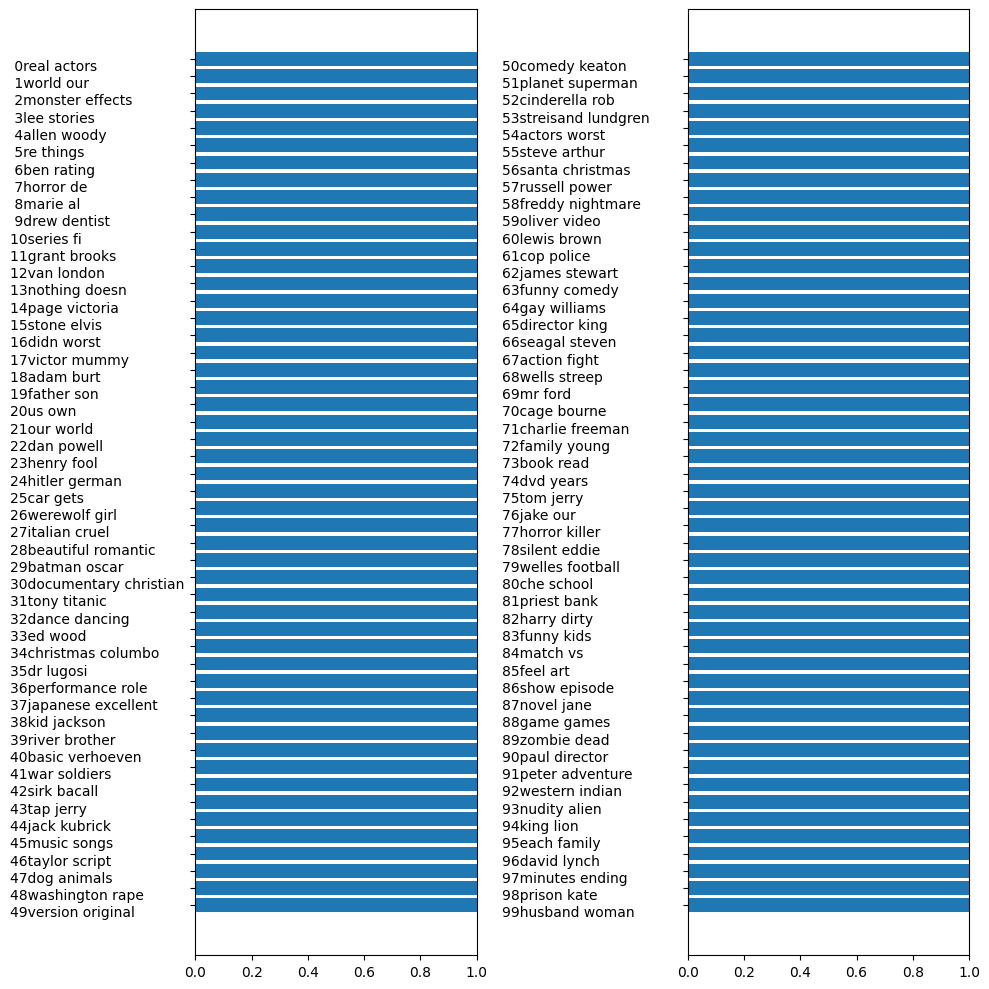

In [72]:
import matplotlib.pyplot as plt
fig, ax=plt.subplots(1,2,figsize=(10,10))
topic_names=["{:>2}".format(i)+" ".join(words)
             for i, words in enumerate(feature_names[sorting[:,:2]])]
for col in [0,1]:
    start=col*50
    end=(col+1)*50
    ax[col].barh(np.arange(50), np.sum(document_topics100, axis=0)[start:end])
    ax[col].set_yticks(np.arange(50))
    ax[col].set_yticklabels(topic_names[start:end], ha="left", va="top")
    ax[col].invert_yaxis()
    ax[col].set_xlim(0, 1)
    yax=ax[col].get_yaxis()
    yax.set_tick_params(pad=130)

plt.tight_layout()

<h1>Создание мешка слов. Я решил спарсить комментарии с последней серии Атаки титанов в csv файл.</h1>

In [18]:
import re
import requests
from bs4 import BeautifulSoup
import pandas as pd
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import time


def scrape_comments(url, num_comments=100):
    options = webdriver.ChromeOptions()
    options.add_argument('--headless')  # Опционально, чтобы браузер не отображался
    options.add_argument('--disable-gpu')  # Необходимо для работы в некоторых окружениях

    driver = webdriver.Chrome(options=options)

    driver.get(url)

    time.sleep(2)

    data = []

    while True:
        try:
            load_more_button = WebDriverWait(driver, 10).until(
                EC.presence_of_element_located((By.CLASS_NAME, 'ipl-load-more__button'))
            )
            load_more_button.click()
            time.sleep(2)
        except Exception as e:
            print(f"Не удалось найти или нажать кнопку 'Загрузить еще': {e}")
            break  # Прекратить цикл, если не удалось найти или нажать кнопку


        soup = BeautifulSoup(driver.page_source, 'html.parser')
        review_containers = soup.find_all('div', class_='review-container')

        for review_container in review_containers:
            user_name = review_container.find('span', class_='display-name-link')
            review_date = review_container.find('span', class_='review-date')
            comment_text = review_container.find('div', class_='text show-more__control')
            rating = review_container.find('span', class_='rating-other-user-rating')

            if user_name and review_date and comment_text:
                user_name = user_name.text.strip()
                review_date = review_date.text.strip()
                comment_text = comment_text.text.strip()

                rating_value = re.search(r'\d+', rating.text.strip()).group() if rating else None

                data.append({
                    'User Name': user_name,
                    'Review Date': review_date,
                    'Comment Text': comment_text,
                    'Rating': rating_value
                })

            if len(data) >= num_comments:
                break

    driver.quit()

    return data

def create_csv(data, csv_filename='comments_dataset.csv'):
    df = pd.DataFrame(data)
    df.to_csv(csv_filename, index=False)
    print(f'CSV файл "{csv_filename}" успешно создан.')



if __name__ == "__main__":
    url = 'https://www.imdb.com/title/tt27048168/reviews?sort=submissionDate&dir=desc&ratingFilter=0'  # Замените на URL страницы с комментариями
    num_comments_to_scrape = 100

    scraped_data = scrape_comments(url, num_comments=num_comments_to_scrape)
    create_csv(scraped_data)


Не удалось найти или нажать кнопку 'Загрузить еще': Message: element not interactable
  (Session info: chrome-headless-shell=120.0.6099.71)
Stacktrace:
0   chromedriver                        0x00000001004544cc chromedriver + 4162764
1   chromedriver                        0x000000010044c654 chromedriver + 4130388
2   chromedriver                        0x00000001000a39f8 chromedriver + 293368
3   chromedriver                        0x00000001000eb870 chromedriver + 587888
4   chromedriver                        0x00000001000df994 chromedriver + 539028
5   chromedriver                        0x00000001000df250 chromedriver + 537168
6   chromedriver                        0x0000000100129ab0 chromedriver + 842416
7   chromedriver                        0x00000001000dd6bc chromedriver + 530108
8   chromedriver                        0x00000001000de930 chromedriver + 534832
9   chromedriver                        0x0000000100419df8 chromedriver + 3923448
10  chromedriver                   

In [20]:
df = pd.read_csv('/Users/ernazerkinbekov/Desktop/bigData/comments_dataset.csv', encoding='latin-1')
#Первые 10 строк нашего датасета
df.head(10)


,User Name,Review Date,Comment Text,Rating
0,DoctorDragon,13 December 2023,The ending of Attack on Titan leaves viewers w...,10
1,IPyaarCinema,12 December 2023,Attack on Titan is the most intricate and well...,10
2,MarvellousApollo,26 November 2023,"The ending dared to amaze\nIt was New, Fresh, ...",10
3,murphyodhran,24 November 2023,My favourite show of all time. This conclusion...,8
4,lilag-80710,24 November 2023,"What a horrible idea that ""the genocide can be...",2
5,arunchittalil-46160,23 November 2023,This episode from Attack on Titan is the best ...,10
6,diko-55552,20 November 2023,"The plan was apparently ""murder 80% of the wor...",1
7,kudarijanhvi,20 November 2023,I'm a very huge attack on titan fan since 2019...,10
8,badansazetim,19 November 2023,I think Isayama had decided from the very begi...,6
9,machinegunsword,19 November 2023,I've been a fan of this series since 2020 and ...,10


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114 entries, 0 to 113
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   User Name     114 non-null    object
 1   Review Date   114 non-null    object
 2   Comment Text  114 non-null    object
 3   Rating        114 non-null    int64 
dtypes: int64(1), object(3)
memory usage: 3.7+ KB


<h1>Распределяю комментарии по их рейтингу, на отрицательные и положительные классы</h2>

In [26]:
df['target'] = df['Rating'].apply(lambda x: 'neg' if x < 7 else 'pos')

<h1>Просмотр к какому из классов принадлежат комментарии</h1>

In [27]:
df['target']

0      pos
1      pos
2      pos
3      pos
4      neg
      ... 
109    pos
110    pos
111    pos
112    pos
113    pos
Name: target, Length: 114, dtype: object

<h1>Число положительных и отрицательных комментариев</h1>

In [28]:
rating_counts = df['target'].value_counts()
rating_counts

target
pos    94
neg    20
Name: count, dtype: int64

<h1>Импорт нужных нам модулей</h1>

In [31]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

In [33]:
text_train, text_test, y_train, y_test = train_test_split(df['Comment Text'], df['target'], test_size=0.2, random_state=42)

<h1>Обучаю модель при помощи CountVectorizer</h1>

In [ ]:
text_train, text_test, y_train, y_test = train_test_split(df['Comment Text'], df['target'], test_size=0.2,
                                                          random_state=42)
vect = CountVectorizer().fit(text_train)
X_train = vect.transform(text_train)
print('X_train:\n{}'.format(repr(X_train)))
feature_names = vect.get_feature_names_out()
print('Количество признаков: {}'.format(len(feature_names)))
print('Первые 20 признаков: {}'.format(feature_names[:20]))
print('Признаки с 20 до 100: {}'.format(feature_names[20:100]))

In [34]:
vect = CountVectorizer().fit(text_train)
X_train = vect.transform(text_train)
print('X_train:\n{}'.format(repr(X_train)))

X_train:
<91x2007 sparse matrix of type '<class 'numpy.int64'>'
	with 12710 stored elements in Compressed Sparse Row format>


In [36]:
feature_names = vect.get_feature_names_out()
print('Количество признаков: {}'.format(len(feature_names)))
print('Первые 20 признаков: {}'.format(feature_names[:20]))
print('Признаки с 20 до 100: {}'.format(feature_names[20:100]))

Количество признаков: 2007
Первые 20 признаков: ['10' '100' '119' '122' '137' '138' '15' '180' '1900s' '20' '200' '2000'
 '2019' '2020' '2021' '21st' '2d' '3d' '50' '500']
Признаки с 1000 до 1020: ['50ft' '80' 'abandon' 'abandoned' 'ability' 'able' 'about' 'above'
 'absolute' 'absolutely' 'absorb' 'absurdly' 'abuser' 'abusive' 'accept'
 'accident' 'accomplish' 'accomplished' 'according' 'achieved' 'achieving'
 'ackerman' 'ackermans' 'across' 'acting' 'action' 'actions' 'activated'
 'actors' 'actual' 'actually' 'adapt' 'adaptation' 'adapting' 'add'
 'added' 'addition' 'admit' 'adult' 'advice' 'advise' 'affect' 'affection'
 'after' 'aftermath' 'again' 'againarmin' 'against' 'agency' 'ago' 'agree'
 'agreed' 'agrees' 'aired' 'alarming' 'alas' 'albeit' 'alive' 'all'
 'alliance' 'allowing' 'almost' 'alone' 'along' 'alongside' 'alot'
 'already' 'alright' 'also' 'alter' 'alternate' 'alternatives' 'although'
 'always' 'am' 'amaze' 'amazed' 'amazing' 'amazingly' 'among']


<h1>Проверка баланса классов. Если условие выполняется, применяем логистическую регрессию с использованием кросс-валидации и выводим среднюю точность.</h1>

In [82]:
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder

# Предположим, что ваш DataFrame называется df

X_train, X_test, y_train, y_test = train_test_split(df['Comment Text'], df['target'], test_size=0.2, random_state=42)

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)

# Создание векторизатора для текстовых данных
vect = CountVectorizer().fit(X_train)
X_train = vect.transform(X_train)

# Проверка распределения классов
unique_classes, class_counts = np.unique(y_train, return_counts=True)
print("Распределение по классам:", dict(zip(unique_classes, class_counts)))

# Продолжение с кросс-валидацией, если классы сбалансированы
if len(unique_classes) >= 2:
    scores = cross_val_score(LogisticRegression(max_iter=1000), X_train, y_train_encoded, cv=5)
    print("Средняя кросс-валид точность: {:.2f}".format(np.mean(scores)))
else:
    print("Недостаточно классов в обучающих данных.")


Распределение по классам: {'neg': 14, 'pos': 77}
Средняя кросс-валид точность: 0.97


<h1>Определяем оптимальные параметры модели Logistic Regression с использованием Grid Search и кросс-валидации на предоставленных данных</h1>

In [83]:
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# Check class distribution
unique_classes, class_counts = np.unique(y_train, return_counts=True)
print("Распределение по классам:", dict(zip(unique_classes, class_counts)))

# Continue with grid search if classes are balanced
if len(unique_classes) >= 2:
    param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
    grid = GridSearchCV(LogisticRegression(max_iter=3000), param_grid, cv=5)
    grid.fit(X_train, y_train)
    print('Наилучшая оценка кросс-валидации: {:.2f}'.format(grid.best_score_))
    print('Наилучшие параметры: ', grid.best_params_)
else:
    print("Недостаточно классов в обучающих данных.")

Распределение по классам: {'neg': 14, 'pos': 77}
Best Cross-Validation Score: 0.97
Best Parameters:  {'C': 0.1}


In [39]:
from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer(min_df=10).fit(text_train)
X_train = vect.transform(text_train)
print("X_train c min_df: {}".format(repr(X_train)))

X_train c min_df: <91x357 sparse matrix of type '<class 'numpy.int64'>'
	with 8569 stored elements in Compressed Sparse Row format>


In [42]:
feature_names = vect.get_feature_names_out()
print('Количество признаков: {}'.format(len(feature_names)))
print('Первые 20 признаков: {}'.format(feature_names[:20]))
print('Признаки с 20 до 100: {}'.format(feature_names[20:100]))

Количество признаков: 357
Первые 20 признаков: ['10' 'able' 'about' 'across' 'action' 'actions' 'after' 'all' 'almost'
 'already' 'also' 'always' 'amazing' 'among' 'an' 'and' 'animation'
 'anime' 'answer' 'any']
Признаки с 20 до 100: ['aot' 'are' 'argument' 'armin' 'as' 'asks' 'at' 'atrocities' 'attack'
 'author' 'baby' 'back' 'be' 'beautiful' 'became' 'because' 'been'
 'beginning' 'being' 'believe' 'best' 'better' 'body' 'breathtaking'
 'brilliant' 'but' 'by' 'can' 'case' 'cause' 'change' 'character'
 'characters' 'choice' 'choices' 'clue' 'colossal' 'come' 'complex'
 'conclusion' 'conflict' 'constructed' 'converged' 'cornerstone' 'could'
 'credits' 'crowd' 'dark' 'death' 'decided' 'did' 'didn' 'died' 'dies'
 'divine' 'do' 'doesn' 'don' 'done' 'dubbing' 'during' 'emotional' 'end'
 'ended' 'ending' 'entire' 'episode' 'eren' 'especially' 'even' 'ever'
 'everlasting' 'every' 'everyone' 'everything' 'evil' 'evolution'
 'experience' 'explain' 'explanation']


<h1>Выводим исходные слова первого отзыва, отфильтрованные слова без стоп-слов и токенизированные слова первого отзыва. Это нужно для демонстрации изменений, внесенных фильтрацией стоп-слов</h1>

In [53]:
import nltk
from nltk.tokenize import word_tokenize
from stop_words import get_stop_words

# Загрузка ресурса punkt
nltk.download('punkt')

# Загрузка стоп-слов для английского языка
stop_words = set(get_stop_words('en'))

# Загрузка текста отзывов
reviews = df['Comment Text'].tolist()

# Токенизация текста
tokenized_reviews = [word_tokenize(review) for review in reviews]

# Применение стоп-слов
filtered_reviews = [
    [word.lower() for word in review if word.lower() not in stop_words and word.isalpha()]
    for review in tokenized_reviews
]

# Вывод результата (вывод может быть длинным)
print("Исходные слова:\n", reviews[0])
print("\n\nОтфильтрованные слова (без стоп-слов):\n", filtered_reviews[0])
print("\n\nТокенизированные слова:\n", tokenized_reviews[0])


Исходные слова:
 The ending of Attack on Titan leaves viewers without much explanation, which is the main reason I read negative reviews among people.It's only natural that there are these two opposing viewpoints: some people like to be able to reason about what happened and reflect to figure out what the true message of the series was, with their own interpretation, while others want to be guided to the underlying message by the viewing experience itself.So I decided to illustrate my point of view, constructed by reasoning with multiple people and observing various perspectives:Eren dies when he kisses Historia's hand in season 3. From that moment, he sees the massacre that will happen, and he asks to himself...how is it possible for me to do such a thing? At the end of season 3 we see him pointing his finger across the sea and wondering if that is the solution. There we already had the clue about the character's evolution, with his gaze lost in the void and the future. When talking t

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/ernazerkinbekov/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


<h1>Вывожу первые 20 строк датасета для демонстрации полученной TF-IDF матрицы.</h1>

In [56]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

# Пример, используя ваш DataFrame df и столбец 'Review'
corpus = df['Comment Text'].tolist()

# Создание экземпляра TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.85, min_df=0.1, max_features=500)

# Преобразование текста в TF-IDF матрицу
tfidf_matrix = tfidf_vectorizer.fit_transform(corpus)

# Получение списка фич (слов) из TfidfVectorizer
feature_names_tfidf = tfidf_vectorizer.get_feature_names_out()

# Создание DataFrame для отображения результата
tfidf_df = pd.DataFrame(data=tfidf_matrix.toarray(), columns=feature_names_tfidf)

# Вывод первых нескольких строк DataFrame с TF-IDF данными
print(tfidf_df.head(20))

          10        80      able    action   actions   amazing  animation  \
0   0.000000  0.000000  0.063755  0.000000  0.127510  0.000000   0.045761   
1   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   0.144612   
2   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   0.000000   
3   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   0.165010   
4   0.096244  0.000000  0.096244  0.000000  0.096244  0.000000   0.000000   
5   0.639103  0.000000  0.000000  0.113869  0.000000  0.000000   0.076454   
6   0.000000  0.105038  0.055625  0.029732  0.027813  0.000000   0.000000   
7   0.000000  0.000000  0.000000  0.000000  0.000000  0.155787   0.097007   
8   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   0.000000   
9   0.000000  0.000000  0.000000  0.112716  0.000000  0.000000   0.075680   
10  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   0.000000   
11  0.161408  0.000000  0.000000  0.000000  0.000000  0.000000   0.000000   

<h1>Выводим список топ-10 слов с наибольшими отрицательными и положительными коэффициентами.</h1>

In [88]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

corpus = df['Comment Text'].tolist()

# Создание экземпляра TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.85, min_df=0.1, max_features=500)

# Преобразование текста в TF-IDF матрицу
tfidf_matrix = tfidf_vectorizer.fit_transform(corpus)

X_train, X_test, y_train, y_test = train_test_split(tfidf_matrix, df['Rating'], test_size=0.2, random_state=42)

# Создание и обучение модели (в примере - линейная регрессия)
model = LinearRegression()
model.fit(X_train, y_train)

# Исследование коэффициентов модели
coefficients = pd.DataFrame({'Feature': tfidf_vectorizer.get_feature_names_out(), 'Coefficient': model.coef_})
coefficients = coefficients.sort_values(by='Coefficient', ascending=False)

# Вывод топ-10 положительных и топ-10 отрицательных коэффициентов
print("Топ 10 положительных коэф:")
print(coefficients.head(10))

print("\nТоп 10 негативных коэф:  ")
print(coefficients.tail(10))

Топ 10 положительных коэф:
      Feature  Coefficient
101  humanity     6.127769
1          80     4.255031
123      long     4.218258
80    freedom     3.759541
87        got     3.513567
116      know     3.458763
37   conflict     3.354193
220    wanted     3.173638
107   journey     3.153357
118      left     2.950972

Топ 10 негативных коэф:  
      Feature  Coefficient
86       good    -3.249980
233      zeke    -3.404490
194  terrible    -3.510902
127      love    -3.575534
151      past    -3.648008
167    reason    -3.986765
46        did    -4.959348
61       eren    -5.004279
129      main    -5.579925
52      doesn    -6.751709


<h1>Выводы по работе</h1>
Спарсив комментарии о последнем эпизоде атаки титанов с cайта imdb, я сохранил в csv файл отзыв, время, рейтинг и имя пользователя. В ходе работы распределяем на два класса - положительный и отрицательный. Затем, при помощи модуля CountVectorizer включаем в себя токенизацию обучающих данных и построение словаря.

Применив LogisticRegression с использованием кросс-валидации, вывел среднюю точность. Применив nltk создаем стоп слова, принтуем исходный отзыв, затем отфильтрованные слова без стоп-слов, после токенизированные слова первого отзыва. Замечаем изменения фильтрацию стоп-слов.

TF-IDF - я использовал для того, чтобы присвоить большой вес термину, который часто встречается в конкретном документе, но при этом редко встречается в остальных документах корпуса, затем вывел первые 20 строк полученной TF-IDF матрицы. После этого можно было вывести положительные и отрицательные коэфициенты наших отзывов